In [1]:
!pip install qibo qibochem matplotlib scipy numpy pandas scikit-learn qibojit
!pip install git+https://github.com/quantumlib/OpenFermion.git@master#egg=openfermion

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.7/163.7 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.4/289.4 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 78.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 73.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 89.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 91.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.7/269.7 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 kB 33.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 86.6 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [1]:
import qibo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from qibo import models, gates
from qibo.noise import IBMQNoiseModel
from scipy.optimize import minimize, minimize_scalar

from qibochem.driver.molecule import Molecule
from qibochem.ansatz import hf_circuit, ucc_circuit
from qibochem.measurement import expectation, expectation_from_samples
from qibochem.ansatz import he_circuit

from qibo.hamiltonians import SymbolicHamiltonian

from qibochem.driver.hamiltonian import fermionic_hamiltonian

from openfermion.transforms import *
from openfermion.transforms import binary_code_transform
from openfermion.chem import MolecularData
from openfermion.transforms import get_fermion_operator
from openfermion.utils import up_then_down

from functools import reduce, lru_cache
from qibo import symbols
from tqdm import tqdm

In [2]:
qibo.set_backend('numpy')
# qibo.set_device("/GPU:0")
# qibo.set_backend('numpy')
qibo.set_device("/CPU:0")
qibo.get_device()

[Qibo 0.2.12|INFO|2024-11-07 11:10:59]: Using numpy backend on /CPU:0
[Qibo 0.2.12|INFO|2024-11-07 11:10:59]: Using numpy backend on /CPU:0


'/CPU:0'

In [3]:
# Declaring Constants
E_HF = -1.1176 
E_FCI = -1.1357 # https://pennylane.ai/qml/demos/tutorial_vqe/
EQ_X = 0.7414 # https://cccbdb.nist.gov/exp2x.asp?casno=1333740
E_HF_STR = r'$E_{HF} = -1.1176$'
E_FCI_STR = r'$E_{FCI} = -1.1357$'

In [26]:
# Helper to block print messages
# In particular, "converged SCF energy..."
from IPython.utils.io import capture_output
def block_print(func):
    def func_wrapper(*args, **kwargs):
        with capture_output():
            value = func(*args, **kwargs)
        return value
    return func_wrapper

# Utility function to calculate percentage error
def percentage_error(actual, predicted):
    return 100 * abs((predicted - actual) / actual)

## Encoding Hamiltonian

The H2 molecule is built via PySCF in the `h2(x)` function, where `x` is the bond length between the two Hydrogen atoms.
The Hamiltonian is reduced using a Parity Mapper, saving 2 qubits of resource.

In [5]:
@block_print
def h2(x):
    molecule = Molecule([('H', (0, 0, 0)), ('H', (0, 0, x))])
    molecule.run_pyscf()
    return molecule

# https://quantumai.google/openfermion/tutorials/binary_code_transforms
def parity_mapped_hamiltonian(molecule):
    hamiltonian = fermionic_hamiltonian(molecule.oei, molecule.tei, molecule.e_nuc)
    hamiltonian = get_fermion_operator(hamiltonian)
    hamiltonian = binary_code_transform(reorder(hamiltonian, up_then_down), 2 * checksum_code(2,1))
    symbolic_ham = sum(
        reduce(lambda x, y: x * y, (getattr(symbols, pauli_op)(qubit) for qubit, pauli_op in pauli_string), coeff)
        # Sums over each individual Pauli string in the QubitOperator
        for operator in hamiltonian.get_operators()
        # .terms gives one operator as a single-item dictionary, e.g. {((1: "X"), (2: "Y")): 0.33}
        for pauli_string, coeff in operator.terms.items()
    )
    return SymbolicHamiltonian(symbolic_ham)

@lru_cache
def make_hamiltonian(x):
    molecule = h2(x)
    return parity_mapped_hamiltonian(molecule)

In [6]:
molecule = h2(EQ_X)
hamiltonian = parity_mapped_hamiltonian(molecule)
print(hamiltonian.form)

-0.339953613441494 + 0.181288808211496*X0*X1 + 0.393983679438515*Z0 + 0.0112365852331823*Z0*Z1 + 0.393983679438515*Z1


## Preparing Ansatz

There are 3 ansatz given below. The first is the Hardware Efficient Ansatz (HEA) where it only uses `RY` and `RZ` rotation gates, as well as `CZ` for qubit entanglement. It avoids the use of `CX` gates as they are known to be inefficient and have lower gate fidelity. While it is relatively short, it has more parameters (4 vs 2) than the second ansatz.

The second ansatz is initialized in the Hartree-Fock (HF) state. Then, the Unitary Coupled Cluster (UCC) circuit, which is a variant of the popular gold standard Coupled Cluster ansatz of quantum chemistry, is appended to it, which allows the ansatz to consider electron excitations when evaluating the molecular energy. However, this ansatz has 4 `CX` gates, which makes it more prone to errors.

The third ansatz is also a Hardware Efficient Ansatz, called the XYZ2F Ansatz, introduced by https://arxiv.org/pdf/2307.03563v2. Its error is comparable to that of the UCC, which gives it a big advantage as it only has 2 two-qubit gates (fSim gates).

In [57]:
nlayers = 1
nqubits = hamiltonian.nqubits
ntheta = 2 * nqubits * nlayers
hea_circuit = he_circuit(2, nlayers)
print(hea_circuit.draw())

[Qibo 0.2.12|WARNING|2024-11-07 11:31:52]: Starting on qibo 0.2.13, ``Circuit.draw`` will work in-place. The in-place method is currently implemented as ``Circuit.display``, but will be renamed as ``Circuit.draw`` on release 0.2.13. In release 0.2.12, the in-place display of circuits is accessible as ``Circuit.display``.


q0: ─RY─RZ─o─Z─
q1: ─RY─RZ─Z─o─


In [58]:
ntheta = 2
uccsd_circuit = hf_circuit(nqubits, molecule.nelec)
uccsd_circuit += ucc_circuit(nqubits, [0, 1])
print(uccsd_circuit.draw())

[Qibo 0.2.12|WARNING|2024-11-07 11:32:41]: Starting on qibo 0.2.13, ``Circuit.draw`` will work in-place. The in-place method is currently implemented as ``Circuit.display``, but will be renamed as ``Circuit.draw`` on release 0.2.13. In release 0.2.12, the in-place display of circuits is accessible as ``Circuit.display``.


q0: ─X─SDG─H─X─RZ─X─H─S───H─X─RZ─X─H───
q1: ─X─H─────o────o─H─SDG─H─o────o─H─S─


In [59]:
class XYZ2F_Circuit(models.Circuit):
    def __init__(
        self,
        nqubits: int,
        accelerators=None,
        density_matrix: bool = False,
        wire_names = None,
    ):
        super().__init__(nqubits, accelerators, density_matrix, wire_names)
        self.add_layer()
        self.compile()

    def add_layer(self):
        self.add(gates.RX(0, theta=0, trainable=True))
        self.add(gates.RY(0, theta=0, trainable=True))
        
        self.add(gates.RX(1, theta=0, trainable=True))
        self.add(gates.RY(1, theta=0, trainable=True))
        
        # self.add(gates.U2(0, phi=0, lam=0, trainable=True))
        # self.add(gates.U2(1, phi=0, lam=0, trainable=True))
        
        self.add(gates.RY(1, theta=0, trainable=True))
        self.add(gates.fSim(0, 1, theta=0, phi=0, trainable=True))
        self.add(gates.RY(1, theta=0, trainable=True))
        
        self.add(gates.RZ(0, theta=0, trainable=True))
        self.add(gates.RZ(1, theta=0, trainable=True))
        
        self.add(gates.RY(1, theta=0, trainable=True).dagger())
        self.add(gates.fSim(0, 1, theta=0, phi=0, trainable=True).dagger())
        self.add(gates.RY(1, theta=0, trainable=True).dagger())
        
        # circuit.add(gates.U2(0, phi=0, lam=0, trainable=True).dagger())
        # circuit.add(gates.U2(1, phi=0, lam=0, trainable=True).dagger())
        
        self.add(gates.RY(0, theta=0, trainable=True).dagger())
        self.add(gates.RX(0, theta=0, trainable=True).dagger())
        
        self.add(gates.RY(1, theta=0, trainable=True).dagger())
        self.add(gates.RX(1, theta=0, trainable=True).dagger())

    def set_parameters(self, parameters):
        u10 = (parameters[0], parameters[1])
        u11 = (parameters[2], parameters[3])
        u2_theta, u2_phi = parameters[4], parameters[5]
        rz0, rz1 = parameters[6], parameters[7]
        parameters = [
            u10[0], u10[1], u11[0], u11[1],
            u2_phi / 2, (u2_theta, u2_phi), -u2_phi / 2,
            rz0, rz1,
            -u2_phi / 2, (u2_theta, u2_phi), u2_phi / 2,
            u10[0], u10[1], u11[0], u11[1]
        ]
        super().set_parameters(parameters)
        

nqubits = 2
ntheta = 8
xyz2f_circuit = XYZ2F_Circuit(nqubits)

print(xyz2f_circuit.draw())

[Qibo 0.2.12|WARNING|2024-11-07 11:32:50]: Starting on qibo 0.2.13, ``Circuit.draw`` will work in-place. The in-place method is currently implemented as ``Circuit.display``, but will be renamed as ``Circuit.draw`` on release 0.2.13. In release 0.2.12, the in-place display of circuits is accessible as ``Circuit.display``.


q0: ─RX─RY────f─RZ───────f─RY─RX────
q1: ─RX─RY─RY─f─RY─RZ─RY─f─RY─RY─RX─


## Measuring Energy Expectation Value

The function evaluates the expected energy given an ansatz circuit, bond length and circuit parameters. It is used as the cost function when performing classical optimization in the next step.

In [60]:
def energy(params, circuit):
    x = params[-1] * 1000
    theta = params[:-1]
    
    hamiltonian = make_hamiltonian(x)
    circuit.set_parameters(theta)
    return expectation(circuit, hamiltonian)

## Classical Optimization

Unlike the standard VQE provided by the library that solves for the ground state given a fixed bond length, the optimization function below solves for both molecular geometry and electronic state at the 
same time. When consecutive results have a difference lower than `tolerance`, the optimization loop will break.

The bond length scale is needed as both circuit parameters and bond length are passed in the same list to the optimizer. The change in circuit parameter will result in a much larger chance in expectation energy compared to the same change in bond length, which will result in inaccurate convergence. Hence, bond length is scaled by a factor of 1000.

In [88]:
BOND_LENGTH_SCALE = 1 / 1000

def optimize(circuit, tolerance: float = 1e-5, max_iter: int = 50, output: bool = False):
    vqe_energies, bond_lengths = [], []
    def callback(x):
        if not output: return
        vqe_energies.append(energy(x, circuit))
        bond_lengths.append(abs(x[-1]) / BOND_LENGTH_SCALE)
    
    num_params = len(circuit.get_parameters())
    params = np.array([np.pi] * num_params + [BOND_LENGTH_SCALE])
    result = minimize(energy, params, args=circuit, tol=tolerance, method="SLSQP",
                      bounds=[(0, 2 * np.pi)] * num_params + [(-3 * BOND_LENGTH_SCALE, 3 * BOND_LENGTH_SCALE)],
                      callback=callback, options={'maxiter': max_iter, 'disp': output})
    return result.fun, abs(result.x[-1]) / BOND_LENGTH_SCALE, vqe_energies, bond_lengths, len(vqe_energies)

final_energy, final_bond_length, vqe_energy, bond_length, it = optimize(uccsd_circuit, output=True)
print(f"Energy: {final_energy:.4f}, {percentage_error(E_FCI, final_energy):.4f}% error")
print(f"Bond Length: {final_bond_length:.4f}, {percentage_error(EQ_X, final_bond_length):.4f}% error")

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1373060241389066
            Iterations: 6
            Function evaluations: 31
            Gradient evaluations: 6
Energy: -1.1373, 0.1414% error
Bond Length: 0.7347, 0.9054% error


Now using Qibo to evaluate the ground state energy, with the same circuit and **known** equilibrium bond length.

In [89]:
vqe = models.VQE(uccsd_circuit, hamiltonian)
initial_parameters = np.array([np.pi] * len(uccsd_circuit.get_parameters()))
best, params, extra = vqe.minimize(initial_parameters, method='SLSQP', compile=False, options={"disp": True})
print(f"Energy: {best:.4f}, {percentage_error(E_FCI, best):.4f}% error")

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1372700881338862
            Iterations: 3
            Function evaluations: 9
            Gradient evaluations: 3
Energy: -1.1373, 0.1382% error


This is the old optimization function, which is significantly slower. (no longer compatible)

In [34]:
def optimize(circuit, tolerance: float = 1e-5, max_iter: int = 100, output: bool = False):    
    # theta, x = np.random.uniform(0, 2 * np.pi, ntheta), np.float64(1.0)
    theta, x = np.array([3.14, 3.14]), np.float64(1.0)
    cur = prev = energy(x, theta, circuit)
    
    it = 1
    vqe_energy, bond_length = [cur], [x]
    with tqdm(total=0, desc="Optimizing", disable=(not output)) as pbar:
        while it < max_iter:
            result = minimize(energy, theta, args=(x, circuit), method="BFGS", options={'maxiter': 1})
            theta = result.x
            
            x_max_iter = max(it, 6) if it <= 10 else max(20 - it, 6)
            result = minimize_scalar(energy, bounds=(0, 2), args=(theta, circuit), options={'maxiter': x_max_iter})
            x = result.x.item()
            
            cur = energy(x, theta, circuit)
            delta = abs(cur - prev)
            
            pbar.set_postfix({
                'E': f"{cur:.6f}",
                'x': f"{x:.6f}",
                'delta': f"{delta:.6f}"
            })
            
            if delta < tolerance:
                break
            
            vqe_energy.append(cur)
            bond_length.append(x)
            prev = cur
            it += 1
            pbar.update(1)

        pbar.close()
        
    return cur, x, vqe_energy, bond_length, it

In [36]:
final_energy, final_bond_length, vqe_energy, bond_length, it = optimize(uccsd_circuit, tolerance=1e-5, output=True)

Optimizing: 9it [00:04,  2.04it/s, E=-1.137304, x=0.734475, delta=0.000005]


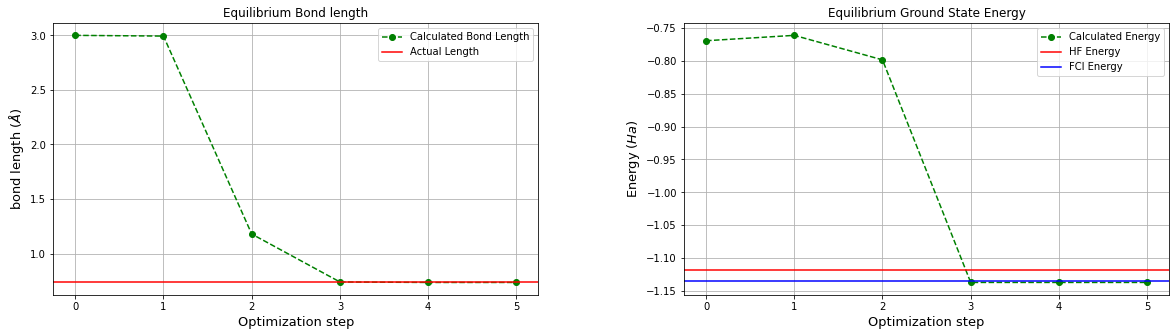

In [66]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(20)

ax1 = fig.add_subplot(121)
ax1.plot(np.arange(0, len(bond_length)), bond_length, "go", ls="dashed", label="Calculated Bond Length")
ax1.axhline(y=EQ_X, color='r', label="Actual Length")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("bond length ($\AA$)", fontsize=13)
ax1.title.set_text("Equilibrium Bond length")
ax1.legend()
ax1.grid(True)

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(0, len(vqe_energy)), vqe_energy, "go", ls="dashed", label="Calculated Energy")
ax2.axhline(y=E_HF, color='r', label="HF Energy")
ax2.axhline(y=E_FCI, color='b', label="FCI Energy")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Energy ($Ha$)", fontsize=13)
ax2.title.set_text("Equilibrium Ground State Energy")
ax2.legend()
ax2.grid(True)

plt.subplots_adjust(wspace=0.3)
plt.show()

## Evaluating Hardware Efficient Ansatz

The HEA efficient ansatz appears to converge to the approximated HF energy in our case, which is not very helpful.

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.1175058742346469
            Iterations: 5
            Function evaluations: 35
            Gradient evaluations: 5
Energy: -1.1175, 1.6020% error
Bond Length: 0.7123, 3.9206% error


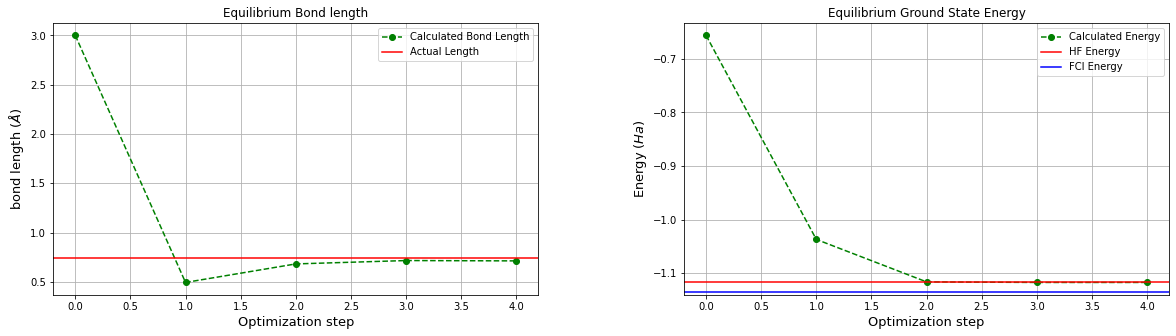

In [91]:
final_energy, final_bond_length, vqe_energy, bond_length, it = optimize(hea_circuit, output=True)
print(f"Energy: {final_energy:.4f}, {percentage_error(E_FCI, final_energy):.4f}% error")
print(f"Bond Length: {final_bond_length:.4f}, {percentage_error(EQ_X, final_bond_length):.4f}% error")

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(20)

ax1 = fig.add_subplot(121)
ax1.plot(np.arange(0, len(bond_length)), bond_length, "go", ls="dashed", label="Calculated Bond Length")
ax1.axhline(y=EQ_X, color='r', label="Actual Length")
ax1.set_xlabel("Optimization step", fontsize=13)
ax1.set_ylabel("bond length ($\AA$)", fontsize=13)
ax1.title.set_text("Equilibrium Bond length")
ax1.legend()
ax1.grid(True)

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(0, len(vqe_energy)), vqe_energy, "go", ls="dashed", label="Calculated Energy")
ax2.axhline(y=E_HF, color='r', label="HF Energy")
ax2.axhline(y=E_FCI, color='b', label="FCI Energy")
ax2.set_xlabel("Optimization step", fontsize=13)
ax2.set_ylabel("Energy ($Ha$)", fontsize=13)
ax2.title.set_text("Equilibrium Ground State Energy")
ax2.legend()
ax2.grid(True)

plt.subplots_adjust(wspace=0.3)
plt.show()

## Energy Landscape

The VQE is evaluated at every 0.05 Angstrom interval to obtain the energy landscape of the H2 molecule. The approximated energy provided by SCF is also shown in the graph. The minimum of the VQE energy is quite close the theoretical FCI energy.

In [93]:
distances = np.arange(0.2, 3.51, 0.05)
scf_energy, vqe_energy = [], []

for x in tqdm(distances, desc="Calculating energies"):
    molecule = h2(x)
    scf_energy.append(molecule.e_hf)
    
    hamiltonian = parity_mapped_hamiltonian(molecule)
    vqe = models.VQE(uccsd_circuit, hamiltonian)
    initial_parameters = np.random.uniform(0, 2 * np.pi, len(uccsd_circuit.get_parameters()))
    best, params, extra = vqe.minimize(initial_parameters, method="SLSQP", compile=False)
    vqe_energy.append(best)
    
scf_energy = np.array(scf_energy)
vqe_energy = np.array(vqe_energy)

Calculating energies: 100%|██████████| 67/67 [00:02<00:00, 28.91it/s]


Minimum SCF Energy: -1.11734903499028
Hartree-Fock Energy: -1.1176
Minimum VQE Energy: -1.1371169840988558
FCI Energy: -1.1357


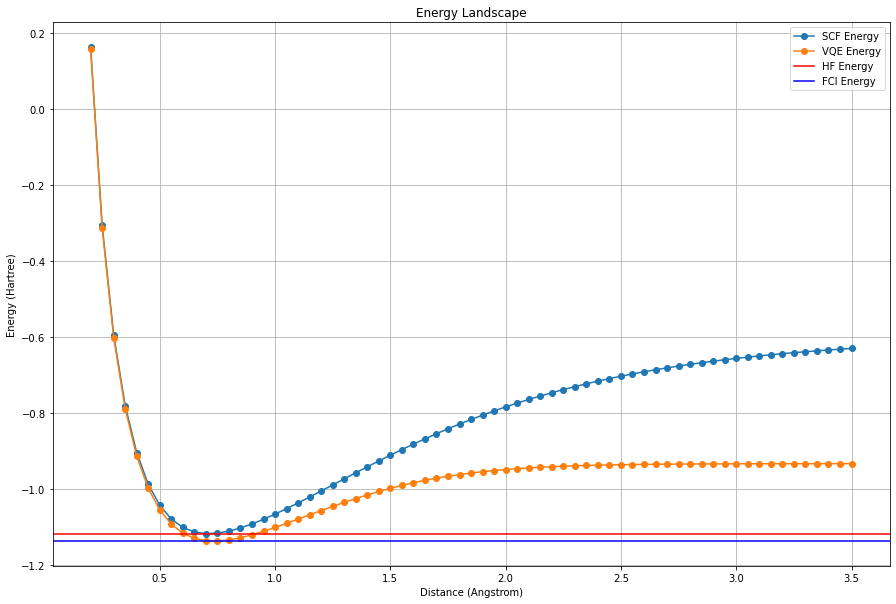

In [94]:
print("Minimum SCF Energy:", scf_energy.min())
print("Hartree-Fock Energy:", E_HF)
print("Minimum VQE Energy:", vqe_energy.min())
print("FCI Energy:", E_FCI)

plt.figure(figsize=(15, 10))
plt.plot(distances, scf_energy, 'o-', label="SCF Energy")
plt.plot(distances, vqe_energy, 'o-', label="VQE Energy")
plt.axhline(y=E_HF, color='r', label="HF Energy")
plt.axhline(y=E_FCI, color='b', label="FCI Energy")
plt.xlabel('Distance (Angstrom)')
plt.ylabel('Energy (Hartree)')
plt.title('Energy Landscape')
plt.legend()
plt.grid(True)
plt.show()

## Noise Simulation
Quantum Computers are extremely prone to errors due to various sources of noise, such as environmental interactions, imperfect control operations, and decoherence. Noise simulation has a few purposes:

- Realistic Evaluation of Algorithm
- Understand the different types of noise and mitigate them
- Benchmarking and find the maximal noise a quantum computer can be exposed to and yet obtain results within a reasonable margin of error

### T1 & T2 Relaxation Times
These are critical parameters in characterizing quantum noise, particularly decoherence.

T1 time is the time constant associated with energy relaxation, where a qubit in an excited state `|1⟩` decays to the ground state `|0⟩`. It represents the lifetime of the qubit's excited state and affects the qubit's ability to retain information.

T2 time is the time constant associated with dephasing, where the relative phase between the qubit's superposition states is lost. It impacts the coherence of quantum superpositions and affects gate fidelity.

### Gate Times
Gate times refer to the duration of quantum gates applied to the qubits. Longer gate times increase exposure to noise and decoherence, leading to higher error rates. Shorter gate times can mitigate these effects but require precise control.


The process is repeated multiples times since noise will introduce randomness. The results are written to a csv file: `energy_acc_qibo2.csv`. The accuracies represent the T1 time in us for the machine, T2 is kept at half of T1. The accuracies chosen to evaluate the algorithm generally follow a log scale.

Note regarding data in `energy_acc_qibo2.csv`:
- `ucc_energy_1` - `ucc_energy_10`: `x_max_iter = 5` in `optimize`, using `UCC` ansatz
- `ucc_energy_11` - `ucc_energy_24`: `x_max_iter = max(it, 10)` in `optimize`, using `UCC` ansatz
- `ucc_energy_25` - `ucc_energy_38`: `x_max_iter = 6` in `optimize`, using `UCC` ansatz
- `ucc_energy_39` - `ucc_energy_48`: `max(it, 6) if it <= 10 else max(20 - it, 6)` in `optimize`, using `XYZ2F` ansatz

In [45]:
for i in range(49, 50):
    accuracies = np.concatenate((np.logspace(0, 12, num=50, base=1.75)[19:], np.array([1024])))
    vqe_energies, bond_lengths = [], []
    for accuracy in tqdm(accuracies, desc="Evaluating simulation"):
        parameters = {
            "t1": accuracy * 1e-6,
            "t2": accuracy * 0.5e-6,
            "gate_times" : (40e-9, 150e-9),
            "excited_population" : 0,
            "depolarizing_one_qubit" : 0,
            "depolarizing_two_qubit": 0,
            "readout_one_qubit" : {"0": 0, "1": 0},
        }
        
        noise_model = IBMQNoiseModel()
        noise_model.from_dict(parameters)
        noisy_circuit = noise_model.apply(uccsd_circuit)
        noisy_circuit.density_matrix = True
        
        print(energy([3.14,3.14,0.7], noisy_circuit))
        
        vqe_energy, x, _, _, _ = optimize(noisy_circuit)
        vqe_energies.append(vqe_energy)
        bond_lengths.append(x)
        
    df = pd.read_csv("energy_acc_qibo2.csv")
    df[f"ucc_energy_{i}"] = vqe_energies
    df.to_csv("energy_acc_qibo2.csv", index=False)

Evaluating simulation:   0%|          | 0/32 [00:00<?, ?it/s]


NotImplementedError: ThermalRelaxationChannel cannot be applied to state vector.

## Curve Fitting & Predicting

There appears to be a deterministic relationship between T1 time and the obtained VQE energy. Therefore, a curve is fit onto the datapoints to obtain a relationship. This can be used to predict the actual ground energy from machines with low T1 time.

The function (after some trial and error) to fit is $ae^{-bx} \cdot x^{-c} + p$, where $a$, $b$, $c$, $p$ are variable.
$p$ is the asymptote of the function and therefore the predicted actual ground energy.

In [16]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

def func(x, a, b, c, p):
    return a * np.exp(-b * x) * np.power(x, -c) + p

def fit_noise_curve(accuracies, data):
    params = curve_fit(f=func, xdata=accuracies, ydata=data, p0=(0.5, 0.05, 0.5, 0),
                bounds=([0, 0, 0.1, -5], [1, 0.1, 1, 0]), maxfev=10000)[0]
    y_fit = func(accuracies, *params)
    return y_fit, params, r2_score(data, y_fit)

In [17]:
df = pd.read_csv("energy_acc_qibo2.csv")

def replace_outliers(row):
    row_mean = np.mean(row)
    row_std = np.std(row)
    threshold = 2 * row_std # Threshold for detecting outliers
    row_cleaned = row.apply(lambda x: row_mean if abs(x - row_mean) > threshold else x)
    return row_cleaned

all_columns = [f'ucc_energy_{i}' for i in range(1, 50)]
using_columns = [f'ucc_energy_{i}' for i in range(49, 50)]
df[all_columns] = df[all_columns].apply(replace_outliers, axis=1)

accuracies = np.concatenate((np.logspace(0, 12, num=50, base=1.75)[19:], np.array([1024])))
vqe_energies = df[using_columns].mean(axis=1)

Parameters: 0.9999999999999855 0.0036895561943607875 0.8235256665846464 -1.1347314421065522
R2 Score: 0.9998429465139296


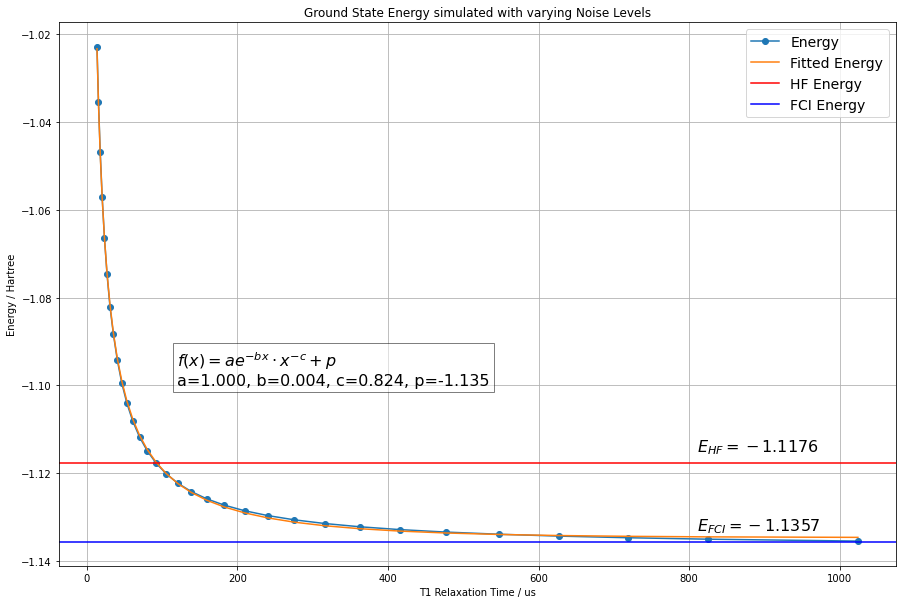

In [18]:
y_fit, params, score = fit_noise_curve(accuracies, vqe_energies)
a, b, c, p = params
print("Parameters:", *params)
print("R2 Score:", score)

plt.figure(figsize=(15, 10))
plt.style.use('fast')
plt.plot(accuracies, vqe_energies, 'o-', label="Energy")
plt.plot(accuracies, y_fit, label="Fitted Energy")
equation_text = r'$f(x) = ae^{-bx} \cdot x^{-c} + p$'
params_text = f'a={a:.3f}, b={b:.3f}, c={c:.3f}, p={p:.3f}'
plt.text(120, -1.10, equation_text + '\n' + params_text, fontsize=16, bbox=dict(facecolor='white', alpha=0.5))
plt.text(810, -1.115, E_HF_STR, fontsize=16)
plt.text(810, -1.133, E_FCI_STR, fontsize=16)
plt.axhline(y=E_HF, color='r', label="HF Energy")
plt.axhline(y=E_FCI, color='b', label="FCI Energy")
plt.title('Ground State Energy simulated with varying Noise Levels')
plt.xlabel('T1 Relaxation Time / us')
plt.ylabel('Energy / Hartree')
plt.grid(True)
plt.legend(fontsize=14)
plt.show()

In [19]:
guesses, pred_errors, normal_errors = [], [], []
for limit in range(6, 32):
    _, (_, _, _, p), _ = fit_noise_curve(accuracies[:limit], vqe_energies[:limit])
    guesses.append(p)
    pred_error = percentage_error(p, E_FCI)
    normal_error = percentage_error(vqe_energies[limit], E_FCI)
    pred_errors.append(pred_error)
    normal_errors.append(normal_error)
    
guesses = np.array(guesses)

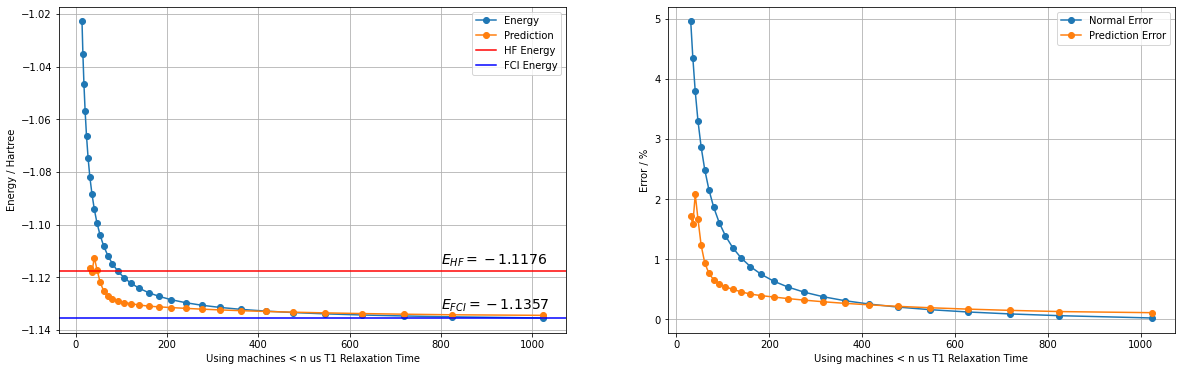

In [20]:
fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(20)

ax1 = fig.add_subplot(121)
ax1.plot(accuracies, vqe_energies, 'o-', label="Energy")
ax1.plot(accuracies[6:], guesses, 'o-', label="Prediction")
ax1.text(800, -1.115, E_HF_STR, fontsize=14)
ax1.text(800, -1.132, E_FCI_STR, fontsize=14)
ax1.axhline(y=E_HF, color='r', label="HF Energy")
ax1.axhline(y=E_FCI, color='b', label="FCI Energy")
ax1.set_xlabel('Using machines < n us T1 Relaxation Time')
ax1.set_ylabel('Energy / Hartree')
ax1.grid(True)
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.plot(accuracies[6:], normal_errors, 'o-', label='Normal Error')
ax2.plot(accuracies[6:], pred_errors, 'o-', label='Prediction Error')
ax2.set_xlabel('Using machines < n us T1 Relaxation Time')
ax2.set_ylabel('Error / %')
ax2.grid(True)
ax2.legend()

plt.show()

In [21]:
# Enter the T1 relaxation time of your quantum computers
accuracies = np.array([15, 30, 40, 50, 100])
samples = 1

vqe_energies = []
for accuracy in tqdm(accuracies, desc="Evaluating simulation"):
    res = []
    for _ in range(samples):
        parameters = {
            "t1": accuracy * 1e-6,
            "t2": accuracy * 0.5e-6,
            "gate_times" : (40e-9, 150e-9),
            "excited_population" : 0,
            "depolarizing_one_qubit" : 0,
            "depolarizing_two_qubit": 0,
            "readout_one_qubit" : {"0": 0, "1": 0},
        }
        
        noise_model = IBMQNoiseModel()
        noise_model.from_dict(parameters)
        noisy_circuit = noise_model.apply(uccsd_circuit)
        noisy_circuit.density_matrix = True
        
        vqe_energy, x, _, _, _ = optimize(noisy_circuit)
        res.append(vqe_energy)
        
    vqe_energies.append(np.array(res).mean())

Evaluating simulation: 100%|██████████| 5/5 [00:06<00:00,  1.28s/it]


T1 Relaxation Times (us):      15         30         40         50         100       
       VQE Energies (Ha):      -1.0325    -1.08077   -1.09376   -1.10205   -1.11926  

Parameters: [ 1.       0.00731  0.81779 -1.13038]
R2 Score: 0.9999936431488582

Extrapolated Energy: -1.13038
Actual Energy (FCI): -1.1357
Predicted Error: 0.46809 %
Normal Error: 1.44737 %


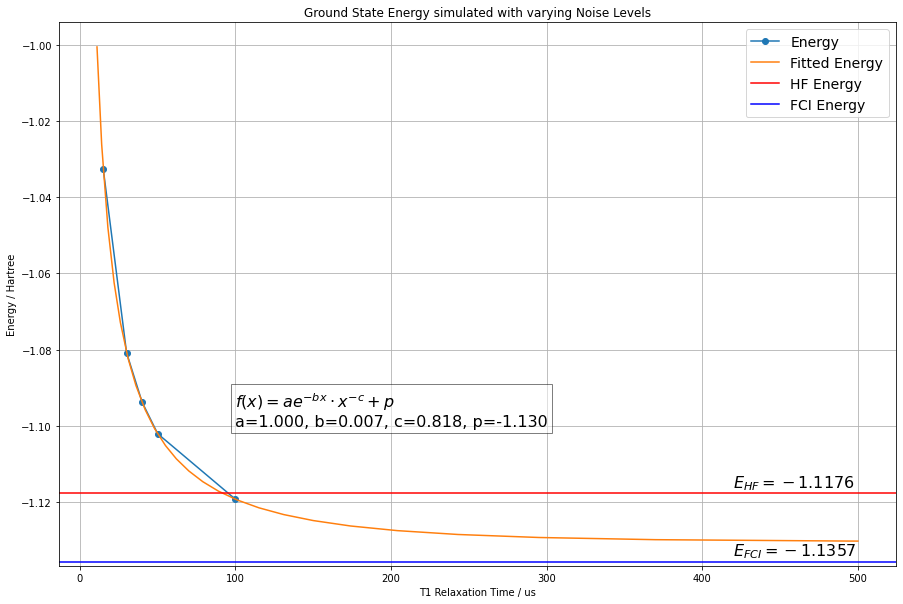

In [22]:
y_fit, params, score = fit_noise_curve(accuracies, vqe_energies)
a, b, c, p = params
print("T1 Relaxation Times (us):".ljust(30), ' '.join(list(map(lambda x: f"{np.round(x, 5):<10}", accuracies))))
print("VQE Energies (Ha):".rjust(25).ljust(30), ' '.join(list(map(lambda x: f"{np.round(x, 5):<10}", vqe_energies))))
print()
print("Parameters:", np.round(params, 5))
print("R2 Score:", score)
print()
print("Extrapolated Energy:", np.round(p, 5))
print("Actual Energy (FCI):", E_FCI)
print("Predicted Error:", np.round(abs((p - E_FCI) / E_FCI) * 100, 5), "%")
print("Normal Error:", np.round(abs((vqe_energies[accuracies.argmax()] - E_FCI) / E_FCI) * 100, 5), "%")

test_accuracies = np.arange(11, 501, 1)
test_fit = func(test_accuracies, *params)

plt.figure(figsize=(15, 10))
plt.style.use('fast')
plt.plot(accuracies, vqe_energies, 'o-', label="Energy")
plt.plot(test_accuracies, test_fit, label="Fitted Energy")
equation_text = r'$f(x) = ae^{-bx} \cdot x^{-c} + p$'
params_text = f'a={a:.3f}, b={b:.3f}, c={c:.3f}, p={p:.3f}'
plt.text(100, -1.10, equation_text + '\n' + params_text, fontsize=16, bbox=dict(facecolor='white', alpha=0.5))
plt.text(420, -1.116, E_HF_STR, fontsize=16)
plt.text(420, -1.134, E_FCI_STR, fontsize=16)
plt.axhline(y=E_HF, color='r', label="HF Energy")
plt.axhline(y=E_FCI, color='b', label="FCI Energy")
plt.title('Ground State Energy simulated with varying Noise Levels')
plt.xlabel('T1 Relaxation Time / us')
plt.ylabel('Energy / Hartree')
plt.grid(True)
plt.legend(fontsize=14)
plt.show()